<a href="https://colab.research.google.com/github/sharonapa/pytorch-classification/blob/master/Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from torch import  nn
import torch.nn.functional as F

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
!git clone https://github.com/jaddoescad/ants_and_bees.git

Cloning into 'ants_and_bees'...
remote: Enumerating objects: 408, done.
remote: Total 408 (delta 0), reused 0 (delta 0), pack-reused 408
Receiving objects: 100% (408/408), 45.03 MiB | 48.84 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [4]:
!ls 

ants_and_bees  sample_data


In [0]:
transform_train = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(0,shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=1, contrast=1,saturation=1),
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ])

transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ])

training_dataset = datasets.ImageFolder(root='ants_and_bees/train', transform=transform_train)
val_dataset = datasets.ImageFolder(root='ants_and_bees/val', transform=transform)

training_loader = torch.utils.data.DataLoader(dataset= training_dataset, batch_size=20, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset= val_dataset, batch_size=20, shuffle=False)

In [0]:
def img_convert(tensor):
  image = tensor.cpu().clone().detach().numpy() #(1,28,28), so to plot it we need :
  image = image.transpose(1,2,0) #(28,28,1)
  image = image * np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5)) #doing de-normalizaion
  image= image.clip(0, 1)
  return image

In [0]:
classes = ('ants', 'bees')

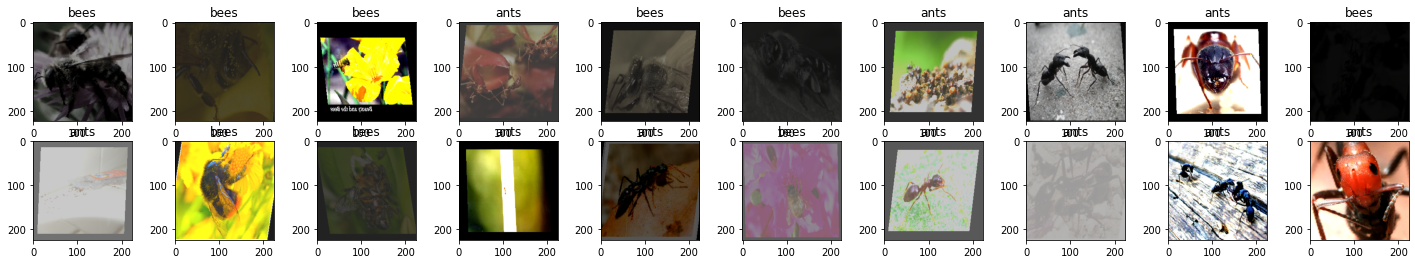

In [8]:
dataiter =  iter(training_loader)
images , labels = dataiter.next()
fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
  ax =fig.add_subplot(2,10, idx+1)
  plt.imshow(img_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [20]:
model = models.resnet50(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [0]:
for param in model.parameters():
  param.requires_grad = False

In [23]:
model.fc = nn.Linear(model.fc.in_features,  len(classes))
# n_input = model.classifier[6].in_features
# last_layer = nn.Linear(n_input , len(classes))
# model.classifier[6] = last_layer
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
sched =torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)

In [27]:
epochs = 10
running_loss_history = []
running_corrects_history =[] #we just want to see how many correct we get while training

val_running_loss_history = []
val_running_corrects_history = []


for i in range(epochs):
  running_loss = 0.0
  running_correct = 0.0

  val_running_loss = 0.0
  val_running_correct = 0.0

  for inputs, labels in training_loader: # looping batch
    inputs = inputs.to(device)
    labels = labels.to(device)

    #inputs = inputs.view(inputs.shape[0], -1) #1, 28,28 -> 1, 784 
    outputs = model.forward(inputs)
    loss = criterion(outputs, labels)
    running_loss+= loss.item()
    
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds= torch.max(outputs, 1)
    running_correct += torch.sum(preds == labels.data)
  else:
    #finished current epoch, let's check on val data
    with torch.no_grad():
      model.eval()
      for val_inputs, val_labels in val_loader: # looping batch
        #val_inputs = val_inputs.view(val_inputs.shape[0], -1) #1, 28,28 -> 1, 784 
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)

        val_outputs = model.forward(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        val_running_loss+= val_loss.item()
        
        _, val_preds= torch.max(val_outputs, 1)
        val_running_correct += torch.sum(val_preds == val_labels.data)
      

    sched.step(val_loss)
    print("finished training on epoch : {}".format(i))

    current_avg_epoch_acc = running_correct/len(training_loader.dataset)
    running_corrects_history.append(current_avg_epoch_acc)

    current_avg_epoch_loss =running_loss/len(training_loader.dataset)
    running_loss_history.append(current_avg_epoch_loss)
    
    print("training loss: {:.4f}, acc: {:.4f}".format(current_avg_epoch_loss,current_avg_epoch_acc))

    current_val_avg_epoch_acc = val_running_correct/len(val_loader.dataset)
    val_running_corrects_history.append(current_val_avg_epoch_acc)

    current_val_avg_epoch_loss =val_running_loss/len(val_loader.dataset)
    val_running_loss_history.append(current_val_avg_epoch_loss)
    
    print("val loss: {:.4f}, acc: {:.4f}".format(current_val_avg_epoch_loss,current_val_avg_epoch_acc))




finished training on epoch : 0
training loss: 0.0602, acc: 0.6885
val loss: 0.0221, acc: 0.8824
finished training on epoch : 1
training loss: 0.0156, acc: 0.8852
val loss: 0.0098, acc: 0.9477
finished training on epoch : 2
training loss: 0.0172, acc: 0.9016
val loss: 0.0105, acc: 0.9412
finished training on epoch : 3
training loss: 0.0124, acc: 0.9180
val loss: 0.0098, acc: 0.9412
finished training on epoch : 4
training loss: 0.0101, acc: 0.9139
val loss: 0.0167, acc: 0.9216
Epoch     6: reducing learning rate of group 0 to 1.0000e-03.
finished training on epoch : 5
training loss: 0.0114, acc: 0.8770
val loss: 0.0127, acc: 0.9412
finished training on epoch : 6
training loss: 0.0084, acc: 0.9385
val loss: 0.0109, acc: 0.9477
finished training on epoch : 7
training loss: 0.0116, acc: 0.9221
val loss: 0.0092, acc: 0.9608
finished training on epoch : 8
training loss: 0.0103, acc: 0.9344
val loss: 0.0092, acc: 0.9608
Epoch    10: reducing learning rate of group 0 to 1.0000e-04.
finished tra

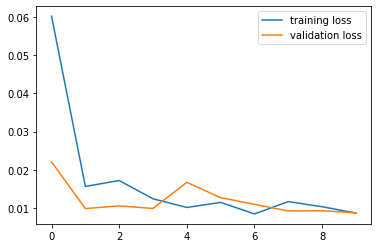

In [28]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

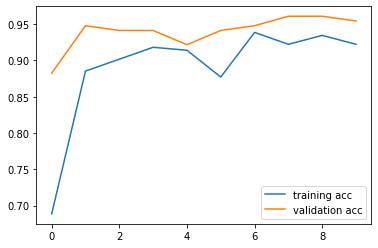

In [29]:
plt.plot(running_corrects_history, label='training acc')
plt.plot(val_running_corrects_history, label='validation acc')
plt.legend()

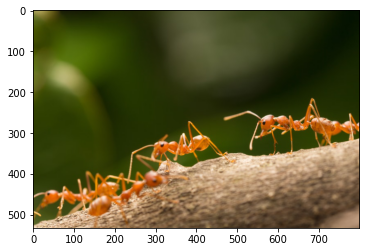

In [30]:
import requests
from PIL import  Image
url = 'https://cdn-prod.servicemaster.com/-/media/Feature/Terminix/Blogs/red-ants-marching-main.jpg?rev=7bf15528c8c14deea7fc30f8d27b8fe4&h=533&w=800&la=en&hash=5D24F94F7C19023A61756535BD8B8A1F'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img);


'ants'

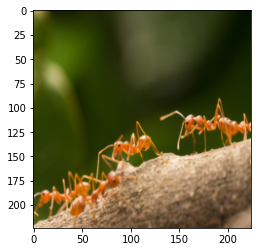

In [31]:
#preprocess image
import PIL
response = requests.get(url, stream = True)
img = Image.open(response.raw)
img = transform(img)
plt.imshow(img_convert(img))

#  infrence
img = img.to(device).unsqueeze(0)

#img = img.view(img.shape[0],-1)
score = model.forward(img)

_, pred = torch.max(score,1)
classes[pred.item()]

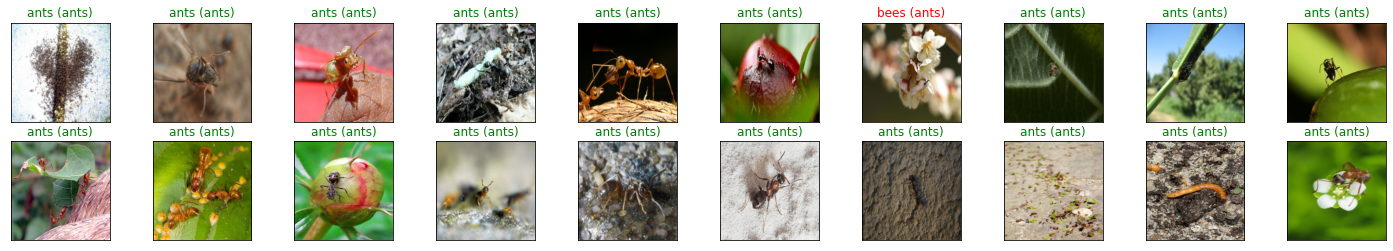

In [32]:

dataiter = iter(val_loader)
images, labels = dataiter.next()
images = images.cuda()
labels = labels.cuda()


#images_ = images.view(images.shape[0], -1)
model.eval()
model = model.cuda()
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
  ax = fig.add_subplot(2,10,idx+1, xticks=[], yticks=[])
  plt.imshow(img_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))

